# Lecture 8, Unsupervised Learning and Model Evaluation

## SVM

In [6]:
import numpy as np
from numpy.linalg import norm
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class SVM:
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma='scale', max_iter=1000, tol=1e-3):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.alpha = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.b = None

    def _kernel_function(self, X1, X2):
        if self.gamma == 'scale':
            self.gamma = 1 / (X1.shape[1] * X1.var())
        
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'poly':
            return (self.gamma * np.dot(X1, X2.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            diff = X1[:, np.newaxis] - X2
            return np.exp(-self.gamma * np.sum(diff ** 2, axis=-1))
        else:
            raise ValueError("Unsupported kernel")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Gram matrix
        K = self._kernel_function(X, X)
        
        # SMO algorithm
        self.alpha = np.zeros(n_samples)
        self.b = 0
        
        for _ in range(self.max_iter):
            alpha_prev = np.copy(self.alpha)
            for i in range(n_samples):
                j = self._random_index(i, n_samples)
                eta = 2.0 * K[i, j] - K[i, i] - K[j, j]
                if eta >= 0:
                    continue
                alpha_i, alpha_j = self.alpha[i], self.alpha[j]
                y_i, y_j = y[i], y[j]
                
                L, H = self._compute_L_H(self.C, alpha_j, alpha_i, y_j, y_i)
                
                self.alpha[j] = alpha_j - (y_j * (self._decision_function(i, X, y, K) -
                                                  self._decision_function(j, X, y, K) -
                                                  y_i + y_j)) / eta
                self.alpha[j] = min(H, max(L, self.alpha[j]))
                
                self.alpha[i] = alpha_i + y_i * y_j * (alpha_j - self.alpha[j])
            
            if np.linalg.norm(self.alpha - alpha_prev) < self.tol:
                break
        
        # Support vectors
        sv = self.alpha > 1e-5
        self.support_vectors = X[sv]
        self.support_vector_labels = y[sv]
        self.alpha = self.alpha[sv]
        
        # Intercept
        self.b = 0
        for n in range(len(self.alpha)):
            self.b += self.support_vector_labels[n]
            self.b -= np.sum(self.alpha * self.support_vector_labels * 
                             K[sv, n])
        self.b /= len(self.alpha)

    def _random_index(self, i, n_samples):
        j = i
        while j == i:
            j = np.random.randint(0, n_samples)
        return j

    def _compute_L_H(self, C, alpha_j, alpha_i, y_j, y_i):
        if y_i != y_j:
            L = max(0, alpha_j - alpha_i)
            H = min(C, C + alpha_j - alpha_i)
        else:
            L = max(0, alpha_i + alpha_j - C)
            H = min(C, alpha_i + alpha_j)
        return L, H

    def _decision_function(self, idx, X, y, K):
        return np.sum(self.alpha * y * K[idx]) - self.b

    def predict(self, X):
        if self.support_vectors is None:
            raise ValueError("Model not fitted yet.")
        K = self._kernel_function(X, self.support_vectors)
        return np.sign(np.dot(K, self.alpha * self.support_vector_labels) + self.b)

# Helper function for accuracy calculation
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

    
X, y = make_circles(n_samples=300, noise=0.1, factor=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
y = np.where(y == 0, -1, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the SVM
svm = SVM(C=1.0, kernel='rbf', gamma='scale')
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

# Calculate accuracy
acc = accuracy(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

Accuracy: 1.00


## K-Means Clustering, Elbow Method, Silhouette Score

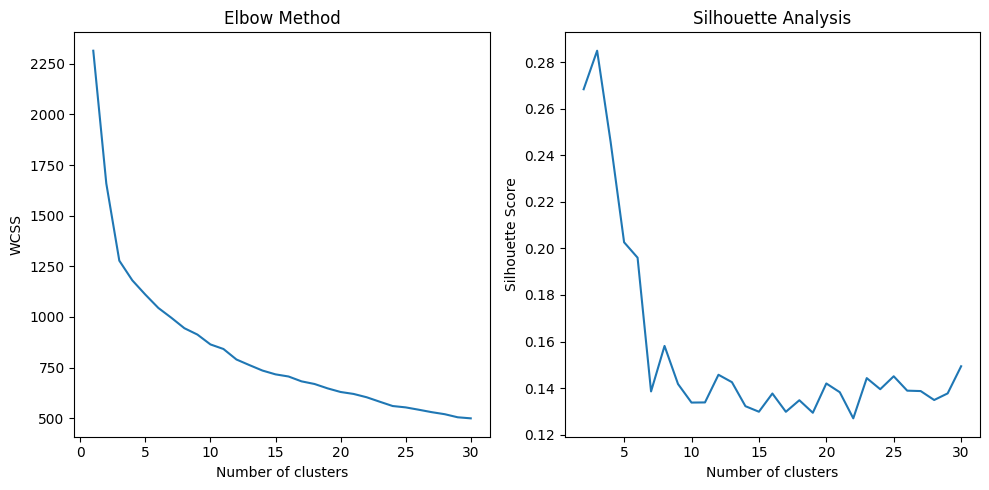

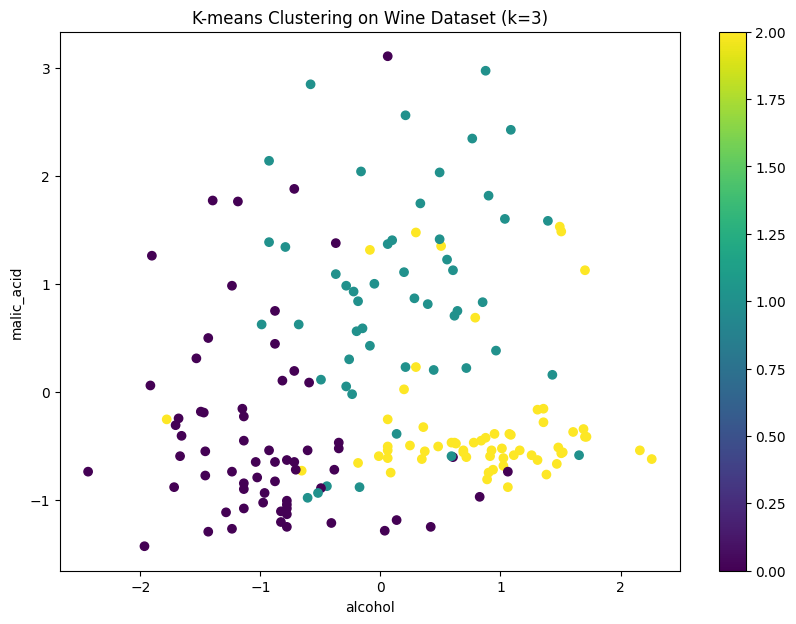

Silhouette Score for 3 clusters: 0.2849
Adjusted Rand Index: 0.8975


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the Wine dataset
wine = load_wine()
X = wine.data
y = wine.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method
wcss = []
max_clusters = 30

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# Silhouette Analysis
silhouette_scores = []

for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Choose the optimal number of clusters (you can adjust this based on the plots)
optimal_clusters = 3

# Apply K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# Visualize the clusters (using the first two features for simplicity)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title(f'K-means Clustering on Wine Dataset (k={optimal_clusters})')
plt.xlabel(wine.feature_names[0])
plt.ylabel(wine.feature_names[1])
plt.show()

# Print the silhouette score for the optimal number of clusters
print(f"Silhouette Score for {optimal_clusters} clusters: {silhouette_score(X_scaled, cluster_labels):.4f}")

# Compare with true labels
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y, cluster_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

In [9]:
X.shape

(178, 13)

In [11]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

## K-Means Clustering, Elbow Method, Silhouette Score, From Scratch

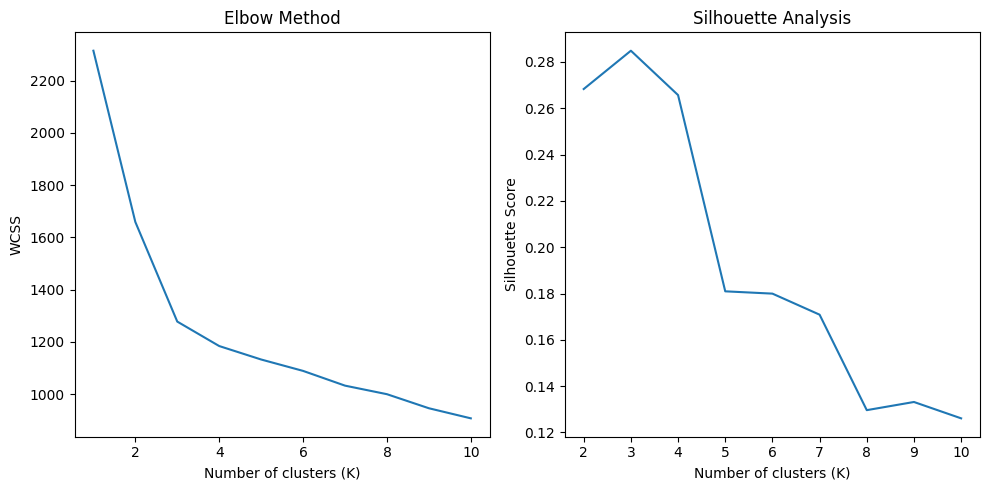

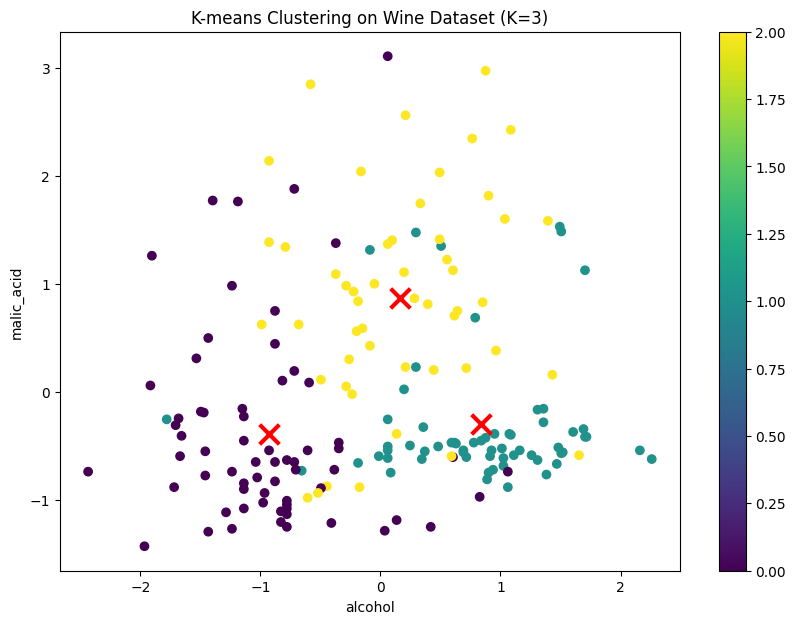

Final Silhouette Score for K=3: 0.2849
Adjusted Rand Index: 0.8975


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KMeans:
    def __init__(self, K=3, max_iters=100, random_state=42):
        self.K = K
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None

    def initialize_centroids(self, X):
        np.random.seed(self.random_state)
        random_idx = np.random.choice(X.shape[0], self.K, replace=False)
        self.centroids = X[random_idx]

    def assign_clusters(self, X):
        clusters = np.zeros(X.shape[0])
        for i, sample in enumerate(X):
            distances = [euclidean_distance(sample, centroid) for centroid in self.centroids]
            cluster = np.argmin(distances)
            clusters[i] = cluster
        return clusters

    def update_centroids(self, X, clusters):
        new_centroids = np.zeros((self.K, X.shape[1]))
        for k in range(self.K):
            new_centroids[k] = np.mean(X[clusters == k], axis=0)
        return new_centroids

    def fit(self, X):
        self.initialize_centroids(X)
        
        for _ in range(self.max_iters):
            clusters = self.assign_clusters(X)
            new_centroids = self.update_centroids(X, clusters)
            
            if np.all(self.centroids == new_centroids):
                break
            
            self.centroids = new_centroids
        
        return clusters

    def get_wcss(self, X):
        clusters = self.assign_clusters(X)
        wcss = 0
        for k in range(self.K):
            wcss += np.sum((X[clusters == k] - self.centroids[k]) ** 2)
        return wcss

def elbow_method(X, max_K):
    wcss = []
    for k in range(1, max_K + 1):
        kmeans = KMeans(K=k)
        kmeans.fit(X)
        wcss.append(kmeans.get_wcss(X))
    return wcss

def silhouette_score(X, clusters):
    n_samples = X.shape[0]
    n_clusters = len(np.unique(clusters))
    
    def calculate_a(X, clusters, i):
        cluster = clusters[i]
        cluster_points = X[clusters == cluster]
        return np.mean([euclidean_distance(X[i], point) for point in cluster_points if not np.array_equal(X[i], point)])
    
    def calculate_b(X, clusters, i):
        cluster = clusters[i]
        other_clusters = [c for c in range(n_clusters) if c != cluster]
        b_values = []
        for other_cluster in other_clusters:
            other_cluster_points = X[clusters == other_cluster]
            b_values.append(np.mean([euclidean_distance(X[i], point) for point in other_cluster_points]))
        return min(b_values) if b_values else 0
    
    s_values = []
    for i in range(n_samples):
        a = calculate_a(X, clusters, i)
        b = calculate_b(X, clusters, i)
        s = (b - a) / max(a, b) if max(a, b) > 0 else 0
        s_values.append(s)
    
    return np.mean(s_values)

# Load and preprocess the Wine dataset
wine = load_wine()
X = wine.data
y = wine.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method
max_K = 10
wcss = elbow_method(X_scaled, max_K)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_K + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')

# Silhouette Analysis
silhouette_scores = []
for k in range(2, max_K + 1):
    kmeans = KMeans(K=k)
    clusters = kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    silhouette_scores.append(score)

plt.subplot(1, 2, 2)
plt.plot(range(2, max_K + 1), silhouette_scores)
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Choose optimal K (you may want to adjust this based on the plots)
optimal_K = 3

# Apply K-means with optimal K
kmeans = KMeans(K=optimal_K)
clusters = kmeans.fit(X_scaled)

# Visualize results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', s=200, linewidths=3)
plt.colorbar(scatter)
plt.title(f'K-means Clustering on Wine Dataset (K={optimal_K})')
plt.xlabel(wine.feature_names[0])
plt.ylabel(wine.feature_names[1])
plt.show()

# Print final silhouette score
final_silhouette_score = silhouette_score(X_scaled, clusters)
print(f"Final Silhouette Score for K={optimal_K}: {final_silhouette_score:.4f}")

# Compare with true labels
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Index: {ari:.4f}")

## Principal Component Analysis

Original dataset shape: (150, 4)

First few rows of the dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


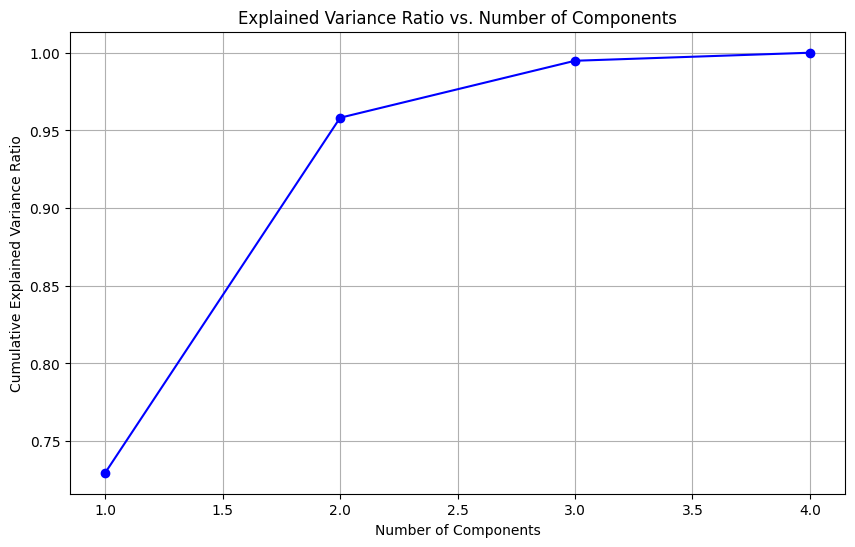


Number of components to keep 95% variance: 2

Reduced dataset shape: (150, 2)

First few rows of the reduced dataset:
        PC1       PC2  target
0 -2.264703  0.480027       0
1 -2.080961 -0.674134       0
2 -2.364229 -0.341908       0
3 -2.299384 -0.597395       0
4 -2.389842  0.646835       0


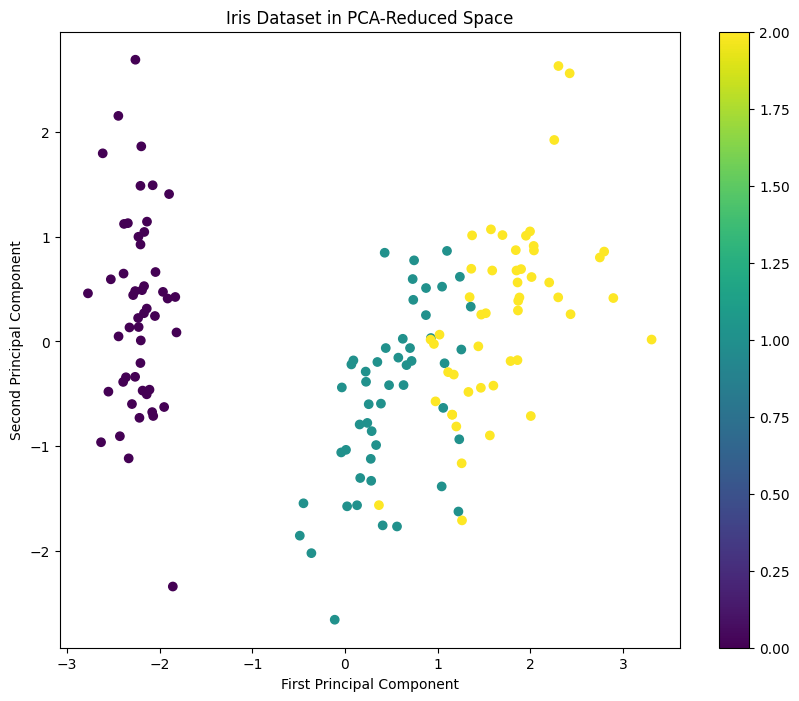


Explained variance ratio for each component:
PC1: 0.7296
PC2: 0.2285

Feature loadings:
                        PC1       PC2
sepal length (cm)  0.521066  0.377418
sepal width (cm)  -0.269347  0.923296
petal length (cm)  0.580413  0.024492
petal width (cm)   0.564857  0.066942


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Create a DataFrame for easier handling
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y

print("Original dataset shape:", X.shape)
print("\nFirst few rows of the dataset:")
print(df.head())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# Choose the number of components (let's say we want to keep 95% of the variance)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nNumber of components to keep 95% variance: {n_components}")

# Apply PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

print("\nReduced dataset shape:", X_pca_reduced.shape)

# Create a new DataFrame with the reduced data
df_pca = pd.DataFrame(data=X_pca_reduced, columns=[f'PC{i+1}' for i in range(n_components)])
df_pca['target'] = y

print("\nFirst few rows of the reduced dataset:")
print(df_pca.head())

# Visualize the first two principal components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=y, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Iris Dataset in PCA-Reduced Space')
plt.colorbar(scatter)
plt.show()

# Print the explained variance ratio for each component
print("\nExplained variance ratio for each component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f}")

# Print the feature loadings
print("\nFeature loadings:")
feature_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=iris.feature_names
)
print(feature_loadings)

In [13]:
pca.explained_variance_ratio_

array([0.72962445, 0.22850762])

In [14]:
import numpy as np

def standardize_data(X):
    mean = np.mean(X, axis=0)
    std_dev = np.std(X, axis=0)
    return (X - mean) / std_dev

def pca(X, n_components):
    X_standardized = standardize_data(X)
    
    covariance_matrix = np.cov(X_standardized, rowvar=False)
    
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_index]
    sorted_eigenvectors = eigenvectors[:, sorted_index]
    
    eigenvector_subset = sorted_eigenvectors[:, :n_components]
    
    X_reduced = np.dot(X_standardized, eigenvector_subset)
    
    return X_reduced

X = np.array([[2.5, 2.4],
                [0.5, 0.7],
                [2.2, 2.9],
                [1.9, 2.2],
                [3.1, 3.0],
                [2.3, 2.7],
                [2, 1.6],
                [1, 1.1],
                [1.5, 1.6],
                [1.1, 0.9]])
    
X_reduced = pca(X, n_components=1)
print("Преобразованные данные:\n", X_reduced)

Преобразованные данные:
 [[ 1.08643242]
 [-2.3089372 ]
 [ 1.24191895]
 [ 0.34078247]
 [ 2.18429003]
 [ 1.16073946]
 [-0.09260467]
 [-1.48210777]
 [-0.56722643]
 [-1.56328726]]
